# Отток клиентов

Задача: предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. Спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Структура данных:

Признаки
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — количество недвижимости у клиента
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата


Целевой признак
- `Exited` — факт ухода клиента


# 1. Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import stats as st
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from joblib import dump, load
from IPython.display import display
import warnings

warnings.simplefilter("ignore") #будем игнорировать предупреждения
SEED = 42 #определяем константу, которая будет инициировать случайные числа

In [ ]:
data = pd.read_csv('/datasets/Churn.csv')
print(display(data.head()))
print(data.info())
print('Дубликатов:', data.duplicated().sum())
print(display(data.drop(['RowNumber', 'CustomerId'], axis = 1).describe()))
    
for column in data:
    if data[column].dtype == 'object':
        print('Признак:', column)
        print('Уникальные:', data[column].value_counts().count())
        print()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None
Дубликатов: 0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


None
Признак: Surname
Уникальные: 2932

Признак: Geography
Уникальные: 3

Признак: Gender
Уникальные: 2



В наших данных 14 признаков и 10000 строк, дубликатов нет, есть пропуски в данных в столбце `Tenure`. Заменим их на 0, а для отметки пропусков создадим отдельный столбец `Tenure_na`:

In [ ]:
data.insert(8, 'Tenure_na', 0)
for i in range(len(data['Tenure'])):
    if pd.isna(data.loc[i,'Tenure']):
        data.loc[i, 'Tenure_na'] = 1    
data['Tenure'] = data['Tenure'].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Tenure_na          10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(9), object(3)
memory usage: 1.1+ MB


Закодируем признаки `Geography` и `Gender` при помощи `One-hot-encoder` (вместо строковых значений отдельные столбцы, где соответсвующий признак будет обозначаться нулем или единицей).

In [ ]:
data = pd.get_dummies(data, dummy_na=False, columns = ['Geography', 'Gender'], drop_first=True )

print(display(data.head()))
print(data.info())

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Tenure_na,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,Hargrave,619,42,2.0,0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,0,83807.86,1,0,1,112542.58,0,0,1,0
2,3,15619304,Onio,502,42,8.0,0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,0,125510.82,1,1,1,79084.10,0,0,1,0


None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
RowNumber            10000 non-null int64
CustomerId           10000 non-null int64
Surname              10000 non-null object
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null float64
Tenure_na            10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(3), int64(9), object(1), uint8(3)
memory usage: 1.0+ MB
None


Признаки `RowNumber`, `CustomerId`, `Surname` мы в нашей задаче использовать не будем. `HasCrCard`, `IsActiveMember` и `Exited` переведем в формат `uint8`, чтобы расчеты производились быстрее:

In [ ]:
data['HasCrCard'] = data['HasCrCard'].astype('uint8')
data['IsActiveMember'] = data['IsActiveMember'].astype('uint8')
data['Exited'] = data['Exited'].astype('uint8')

Посмотрим на основные статистики:

In [ ]:
def stat(row, data=data):
    mean = np.mean(data[row])
    median = np.median(data[row])
    var = np.var(data[row])
    std = np.std(data[row])
    print('Для {}:'.format(row))
    print('Среднее значение {:.3f}'.format(mean))
    print('Медиана {:.3f}'.format(median))
    print('Дисперсия  {:.3f}'.format(var))
    print('Стандартное отклонение  {:.3f}'.format(std))
    print()
for row in data.drop(['RowNumber', 'CustomerId'], axis = 1):
    if data[row].dtype == 'int64' or data[row].dtype == 'float64' or data[row].dtype == 'uint8':
        stat(row, data)

Для CreditScore:
Среднее значение 650.529
Медиана 652.000
Дисперсия  9340.926
Стандартное отклонение  96.648

Для Age:
Среднее значение 38.922
Медиана 37.000
Дисперсия  109.983
Стандартное отклонение  10.487

Для Tenure:
Среднее значение 4.543
Медиана 4.000
Дисперсия  9.681
Стандартное отклонение  3.111

Для Tenure_na:
Среднее значение 0.091
Медиана 0.000
Дисперсия  0.083
Стандартное отклонение  0.287

Для Balance:
Среднее значение 76485.889
Медиана 97198.540
Дисперсия  3893046832.373
Стандартное отклонение  62394.285

Для NumOfProducts:
Среднее значение 1.530
Медиана 1.000
Дисперсия  0.338
Стандартное отклонение  0.582

Для HasCrCard:
Среднее значение 0.706
Медиана 1.000
Дисперсия  0.208
Стандартное отклонение  0.456

Для IsActiveMember:
Среднее значение 0.515
Медиана 1.000
Дисперсия  0.250
Стандартное отклонение  0.500

Для EstimatedSalary:
Среднее значение 100090.240
Медиана 100193.915
Дисперсия  3307126038.456
Стандартное отклонение  57507.617

Для Exited:
Среднее значение 0.204
Ме

Построим диаграмму отношений между всеми парами признаков:

<Figure size 2880x2880 with 0 Axes>

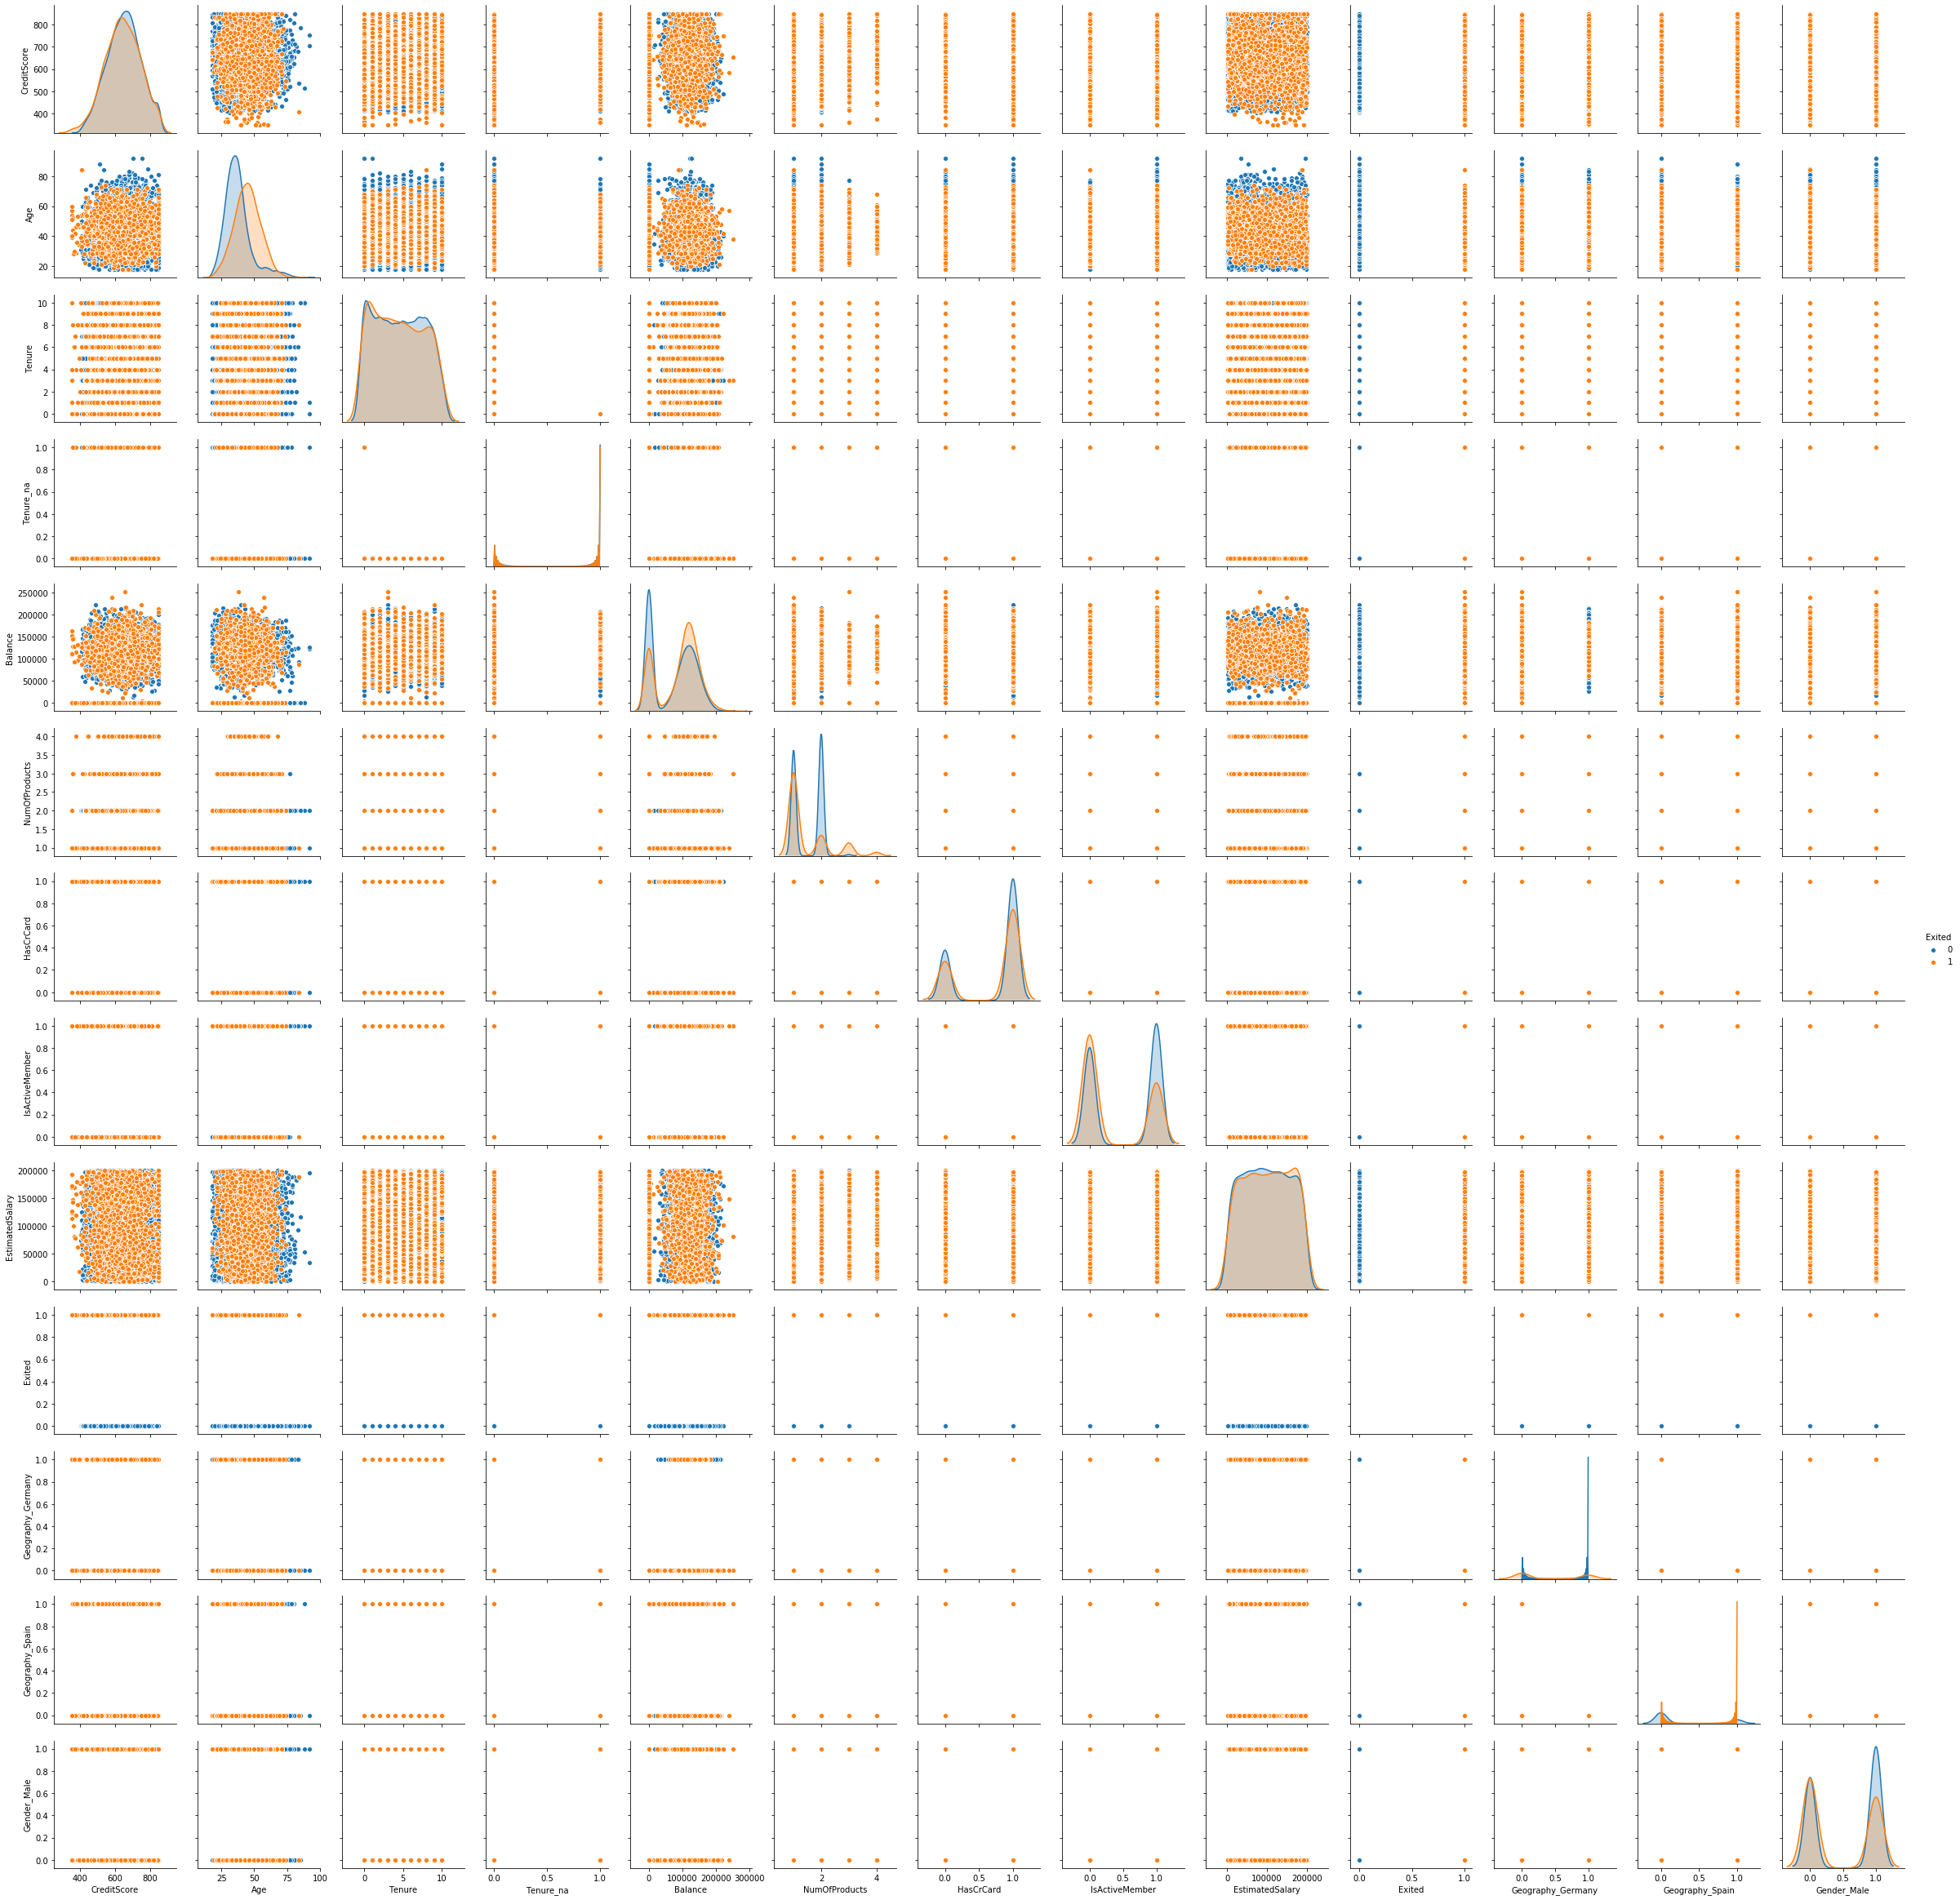

In [ ]:
plt.figure(figsize = (40,40))
sns.pairplot(data=data.drop(['RowNumber', 'CustomerId'], axis = 1), hue="Exited")
plt.show()

По диаграмме видно, что нет четких линейных зависимостей между признаками.

Посмотрим на корреляции нашего целевого признака с прочими признаками:

In [ ]:
def ranking(y, title=''):
    y_pos = np.arange(len(y),0,-1)
    plt.figure(figsize=(8,8))
    #cmap = ['plasma']
    cmap = ListedColormap(sns.color_palette("plasma_r"))
    bar_colors = cmap(y.values)
    plt.barh(y_pos, width=y, height=0.6, left=None, align='center', color=bar_colors, alpha = 0.8)
    plt.yticks(y_pos, y.index)
    plt.title(title)
    plt.xlabel('Корреляция')
    plt.ylabel('Признаки')
    for p, c, ch in zip(y_pos, y.index, round(y,4)):
        plt.annotate(str(ch), xy=(ch if ch>0 else 0, p), va='center')

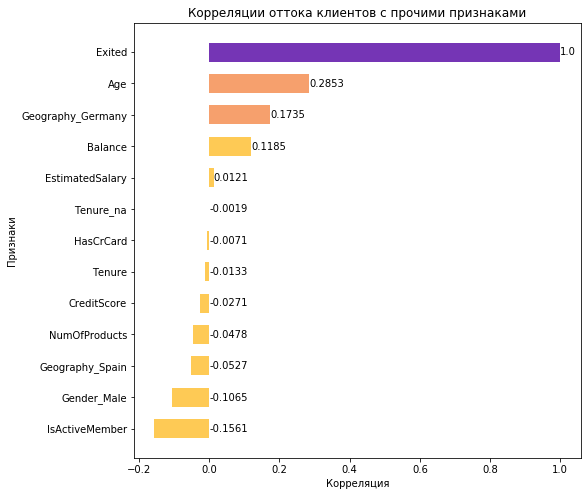

In [ ]:
ranking(data.drop(['RowNumber', 'CustomerId'], axis = 1).corr()['Exited'].sort_values(ascending = False), 'Корреляции оттока клиентов с прочими признаками')

По корреляциям видно, что чем старше клиент и чем больше его баланс, тем больше положительная корреляция с оттоком, у жителей Германии положительная корреляция с оттоком, у жителей Испании - отрицательная. У активных членов и у мужчин отрицательная корреляция с оттоком. Отрицательная корреляция у владельцев нескольких продуктов.

Попробуем построить портрет типичного уходящего клиента:

In [ ]:
display(data.query('Exited == 1').groupby(['Balance', 'NumOfProducts', 'Age', 'Gender_Male', 'Geography_Germany', 'Geography_Spain'])['IsActiveMember'].value_counts().sort_values(ascending = False).head(1))

Balance  NumOfProducts  Age  Gender_Male  Geography_Germany  Geography_Spain  IsActiveMember
0.0      1              49   0            0                  0                0                 9
Name: IsActiveMember, dtype: int64

Портрет типичного уходящего клиента: неактивный клиент женщина из Франции, 49 лет, баланс 0, продукт 1.

Разбьем последовательно выборки на тренировочную, валидационную и тестовую в соотношении `6:2:2` :

Сперва поделим наши данные на `features` (признаки) и `target` (целевой признак)

In [ ]:
features = data.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis =1)
target = data['Exited']

In [ ]:
features_train_val, features_test, target_train_val, target_test = train_test_split(features, target, test_size=0.20, random_state=SEED)
features_train, features_val, target_train, target_val = train_test_split(features_train_val, target_train_val, test_size=0.25, random_state=SEED)
print(features_train.shape, features_val.shape, features_test.shape, target_train.shape, target_val.shape, target_test.shape)

(6000, 12) (2000, 12) (2000, 12) (6000,) (2000,) (2000,)


### Вывод

- Мы изучили данные. дубликатов нет, есть пропуски в данных в столбце Tenure. 
- Заменили пропуски в данных в столбце `Tenure` на 0, а для отметки пропусков создали отдельный столбец `Tenure_na`.
- Закодировали признаки `Geography` и `Gender` при помощи `One-hot-encoder`.
- Признаки `RowNumber`, `CustomerId`, `Surname` мы в нашей задаче использовать не будем. 
- `HasCrCard`, `IsActiveMember` и `Exited` перевели в формат `uint8`.
- Вывели основные статистики для численных признаков.
- Построим диаграмму отношений между всеми парами признаков. По диаграмме видно, что нет четких линейных зависимостей между признаками.
- Посмотрели на корреляции нашего целевого признака с прочими признаками. По корреляциям видно, что чем старше клиент и чем больше его баланс, тем больше положительная корреляция с оттоком, у жителей Германии положительная корреляция с оттоком, у жителей Испании - отрицательная. У активных членов и у мужчин отрицательная корреляция с оттоком. Отрицательная корреляция у владельцев нескольких продуктов.
- Построен портрет типичного уходящего клиента: неактивный клиент женщина из Франции, 49 лет, баланс 0, продукт 1.
- Разбили последовательно выборки на тренировочную, валидационную и тестовую в соотношении `6:2:2` 

# 2. Исследование задачи

Посмотрим, как распределяются классы в нашем целевом признаке:

In [ ]:
target.value_counts(normalize = True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Примерно 80% нулей и 20% единиц - 4:1. Это далеко от 1:1, то есть у нас наблюдается дисбаланс классов.

Как мы можем бороться с проблемой дисбаланса классов: 
- Указать в алгоритме машинного обучения `class_weight='balanced'`, и он сам посчитает баланс.
- Либо использовать технику upsampling (увеличение числа классов меньшего класса путем копирования). 
- Либо использовать технику downsampling (когда убирается часть объектов большего класса). 
- Также мы можем использовать специальные метрики качества, допустим F1-меру (это и будет основной метрикой в нашей задаче)
- Изменять порог классификации - делать его отличным от 0.5, строя ROC-кривую и вычисляя площадь под ней (это будет нашей дополнительной метрикой качества).

Мы будем использовать в нашей задаче параметр  `class_weight='balanced'` и вышеуказанные метрики. Затем попробуем методы upsampling и downsampling.

Попробуем применить следующие алгоритмы машинного обучения: логистическую регрессию, дерево решений, случайный лес и градиентный бустинг. Затем сравним их результаты и выберем лучшую модель.

<div class="alert alert-block alert-success">
Комментарий ревьюера v. 1:
    
Да, верно выборка не является сбалансированной по классам. Молодец, что описала свои планы по борьбе с дисбалансом классов.
</div>

### Вывод

- В нашей задаче наблюдается дисбаланс классов
- Мы будем использовать специальные метрики качества F1-меру и площадь под ROC-кривой — AUCROC. Также будем использовать параметр `class_weight='balanced'`. Попробуем методы upsampling и downsampling.
- Будем применять следующие алгоритмы машинного обучения: логистическую регрессию, дерево решений, случайный лес и градиентный бустинг. Затем выберем лучшую модель.

# 3. Борьба с дисбалансом

Попробуем сперва исследовать модели без учета дисбаланса классов, затем, если алгоритм позволяет, применить `class_weight='balanced'`.

Затем подберем лучшие параметры лучшей модели.

In [ ]:
def train_and_val(model, features_train, features_val, target_train, target_val):
    model.fit(features_train, target_train)
    target_predict = model.predict(features_val)
    f1 = f1_score(target_val, target_predict)
    print('f1 = ', f1)
    probabilities = model.predict_proba(features_val)
    probabilities_ones = probabilities[:,1]
    auc_roc = roc_auc_score(target_val, probabilities_ones)
    print('auc_roc = ', auc_roc)      


Модель логистичской регрессии:

In [ ]:
model = LogisticRegression(random_state = SEED)
train_and_val(model, features_train, features_val, target_train, target_val)

f1 =  0.12981744421906694
auc_roc =  0.681704100050196


In [ ]:
model = LogisticRegression(random_state = SEED, class_weight='balanced')
train_and_val(model, features_train, features_val, target_train, target_val)

f1 =  0.503778337531486
auc_roc =  0.7774914521894754


Как видно, метрика F1 для несбалансированных классов существенно ниже для данной модели.

Модель дерева решений:

In [ ]:
model = DecisionTreeClassifier(random_state = SEED)
train_and_val(model, features_train, features_val, target_train, target_val)

f1 =  0.500587544065805
auc_roc =  0.6869807805855994


In [ ]:
model = DecisionTreeClassifier(random_state = SEED, class_weight='balanced')
train_and_val(model, features_train, features_val, target_train, target_val)

f1 =  0.48905109489051096
auc_roc =  0.677808953192632


Модель случайного леса:

In [ ]:
model = RandomForestClassifier(random_state = SEED)
train_and_val(model, features_train, features_val, target_train, target_val)

f1 =  0.5284178187403994
auc_roc =  0.8174781174524856


In [ ]:
model = RandomForestClassifier(random_state = SEED, class_weight='balanced')
train_and_val(model, features_train, features_val, target_train, target_val)

f1 =  0.5389408099688473
auc_roc =  0.8187299654731008


Модель градиентного бустинга (`class_weight='balanced'` мы здесь применить не можем) :

In [ ]:
model = GradientBoostingClassifier(random_state = SEED)
train_and_val(model, features_train, features_val, target_train, target_val)

f1 =  0.5967016491754122
auc_roc =  0.8693722146190827


Как видим, лучшее значение нашей основной метрики F1 - у модели градиентного бустинга. Подберем ее параметры:

In [ ]:
params = ({'learning_rate': (0.01, 0.05, 0.1, 0.5),
                  'n_estimators': (50, 100, 150, 200, 250),
                  'min_samples_split': (2, 3, 4, 5),
                  'max_depth': (2,3,4,5)
                                                   
                 })
model = GradientBoostingClassifier(random_state = SEED)
model.fit(features_train, target_train)
dump(model, 'best_model.joblib')
best_score=0
for p1 in params.get('learning_rate'):
    for p2 in params.get('n_estimators'):
        for p3 in params.get('min_samples_split'):
            for p4 in params.get('max_depth'):
                
                best_model = load('best_model.joblib')
                best_preds = best_model.predict(features_val)
                best_score = f1_score(target_val, best_preds)
                
                model = GradientBoostingClassifier(random_state = SEED, learning_rate=p1, n_estimators= p2, min_samples_split= p3, max_depth=p4)
                model.fit(features_train, target_train)
                preds = model.predict(features_val)
            
                if f1_score(target_val, preds)> best_score:
                    dump(model, 'best_model.joblib')
                    p_best= {'learning_rate':p1, 'n_estimators':p2, 'min_samples_split':p3, 'max_depth':p4}
print(p_best)
best_model = load('best_model.joblib')
print(f1_score(target_val, best_model.predict(features_val)))

{'learning_rate': 0.1, 'n_estimators': 150, 'min_samples_split': 3, 'max_depth': 5}
0.618705035971223


Применим лучшие параметры модели градиентного бустинга:

In [ ]:
model = GradientBoostingClassifier(random_state = SEED, learning_rate = 0.1, n_estimators = 150, min_samples_split = 3, max_depth = 5)
train_and_val(model, features_train, features_val, target_train, target_val)

f1 =  0.618705035971223
auc_roc =  0.8638514199053753


Попробуем использовать метод upsample и повторить исследование моделей.

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=SEED)
    return features_upsampled, target_upsampled

In [ ]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)
features_val_upsampled, target_val_upsampled = upsample(features_val, target_val, 4)

In [ ]:
model = LogisticRegression(random_state = SEED)
train_and_val(model, features_train_upsampled, features_val_upsampled, target_train_upsampled, target_val_upsampled)

f1 =  0.6827237585489146
auc_roc =  0.7132116119011765


In [ ]:
model = DecisionTreeClassifier(random_state = SEED)
train_and_val(model, features_train_upsampled, features_val_upsampled, target_train_upsampled, target_val_upsampled)

f1 =  0.6117120477433794
auc_roc =  0.682336508343365


In [ ]:
model = RandomForestClassifier(random_state = SEED)
train_and_val(model, features_train_upsampled, features_val_upsampled, target_train_upsampled, target_val_upsampled)

f1 =  0.6441717791411042
auc_roc =  0.8232949006073866


In [ ]:
model = GradientBoostingClassifier(random_state = SEED, learning_rate = 0.1, n_estimators = 150, min_samples_split = 3, max_depth = 5)
train_and_val(model, features_train_upsampled, features_val_upsampled, target_train_upsampled, target_val_upsampled)

f1 =  0.7636482510624386
auc_roc =  0.8585251536775038


Как видим, при таком методе уровень F1 достаточно существенно повысился.

Попробуем использовать метод downsample и повторить исследование моделей.

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=SEED)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=SEED)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=SEED)
    return features_downsampled, target_downsampled

In [ ]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)
features_val_downsampled, target_val_downsampled = downsample(features_val, target_val, 0.25)

In [ ]:
model = LogisticRegression(random_state = SEED)
train_and_val(model, features_train_downsampled, features_val_downsampled, target_train_downsampled, target_val_downsampled)

f1 =  0.6970059880239521
auc_roc =  0.7277401333243881


In [ ]:
model = DecisionTreeClassifier(random_state = SEED)
train_and_val(model, features_train_downsampled, features_val_downsampled, target_train_downsampled, target_val_downsampled)

f1 =  0.6900726392251816
auc_roc =  0.6838272516025152


In [ ]:
model = RandomForestClassifier(random_state = SEED)
train_and_val(model, features_train_downsampled, features_val_downsampled, target_train_downsampled, target_val_downsampled)

f1 =  0.7598944591029023
auc_roc =  0.8363116838760436


In [ ]:
model = GradientBoostingClassifier(random_state = SEED, learning_rate = 0.1, n_estimators = 150, min_samples_split = 3, max_depth = 5)
train_and_val(model, features_train_downsampled, features_val_downsampled, target_train_downsampled, target_val_downsampled)

f1 =  0.784217016029593
auc_roc =  0.8619732741322632


Мы видим очень хорошие результаты при применении данного метода, особенно у моделей случайного леса и градиентного бустинга.

Лучшие результаты показывает модель градиентного бустинга при применении метода upsample.

### Вывод

- Мы исследовали различные модели без учета дисбаланса классов.
- Мы исследовали различные модели с учетом дисбаланса классов различными методами, и получили лучшие значения метрики F1.
- Наилучшие значения метрики F1 дает модель градиентного бустинга со специально подобранными параметрами.
- Наилучшую метрику качества F1 мы получили при использовании метода upsample. 

# 4. Тестирование модели

Проверим работу нашей лучшей модели на тестовых данных (обучим на всей выборке `train_val`, применив к ней метод upsample):

In [ ]:
features_train_val_upsampled, target_train_val_upsampled = upsample(features_train_val, target_train_val, 4)
model = GradientBoostingClassifier(random_state = SEED, learning_rate = 0.1, n_estimators = 150, min_samples_split = 3, max_depth = 5)
model.fit(features_train_val_upsampled, target_train_val_upsampled)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=3,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
target_predict = model.predict(features_test)
f1 = f1_score(target_test, target_predict)
print('f1 = ', f1)
probabilities = model.predict_proba(features_test)
probabilities_ones = probabilities[:,1]
auc_roc = roc_auc_score(target_test, probabilities_ones)
print('auc_roc = ', auc_roc)      


f1 =  0.5955649419218585
auc_roc =  0.8587350823607278


Как видим, значение F1 метрики на тестовых данных не настолько большое, однако удалось достичь желаемого значение 0.59.

Построим для лучшей модели ROC-кривую:

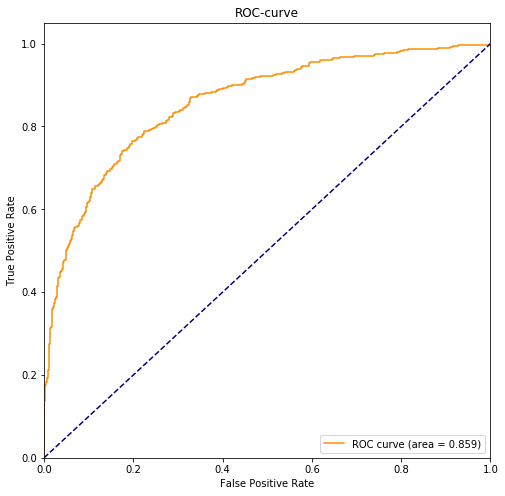

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_ones)

plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.3f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.show()

<a id='section41'></a>

### Вывод

- Мы достигли результата - метрика F1 = 0.596.
- Построили ROC-кривую для нашей лучшей модели.

# 5. Общий вывод

- Мы изучили данные. дубликатов нет, есть пропуски в данных в столбце Tenure. 
- Заменили пропуски в данных в столбце `Tenure` на 0, а для отметки пропусков создали отдельный столбец `Tenure_na`.
- Закодировали признаки `Geography` и `Gender` при помощи `One-hot-encoder`.
- Признаки `RowNumber`, `CustomerId`, `Surname` мы в нашей задаче использовать не будем. 
- `HasCrCard`, `IsActiveMember` и `Exited` перевели в формат `uint8`для быстроты рассчетов.
- Вывели основные статистики для численных признаков.
- Построим диаграмму отношений между всеми парами признаков. По диаграмме видно, что нет четких линейных зависимостей между признаками.
- Посмотрели на корреляции нашего целевого признака с прочими признаками. 
- Построен портрет типичного уходящего клиента: неактивный клиент женщина из Франции, 49 лет, баланс 0, продукт 1.
- Разбили последовательно выборки на тренировочную, валидационную и тестовую в соотношении `6:2:2` .

- В нашей задаче наблюдается дисбаланс классов
- Мы применили следующие алгоритмы машинного обучения: логистическую регрессию, дерево решений, случайный лес и градиентный бустинг. 
 - Мы использовали специальные метрики качества F1-меру и площадь под ROC-кривой — AUCROC.
- Мы исследовали различные модели без учета дисбаланса классов.
- Мы исследовали различные модели с учетом дисбаланса классов различными методами (параметр `class_weight='balanced'`, методы upsampling и downsampling).
- Наилучшие значения метрики F1 дает модель градиентного бустинга со специально подобранными параметрами.
- Наилучшую метрику качества F1 мы получили при использовании метода upsample. 
- Мы достигли результата - метрика `F1 = 0.596`.
- Построили ROC-кривую для нашей лучшей модели.